In [1]:
# !git clone https://github.com/Kemsekov/kemsekov_torch

19917 


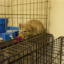

In [2]:
# load dataset for diffusion model to learn
import os
import PIL
import numpy as np
import torch
import torch.nn as nn
import random
from kemsekov_torch.train import split_dataset
import torchvision.transforms as T

# if some images have alpha we replace it with zeros
def process_alpha_image(img):
    # Open the image and convert to RGB from RGBA
    img_array = np.array(img)
    if len(img_array.shape)<3: return img
    if img_array.shape[-1]<4: 
        return img
    # Split into channels
    r, g, b, a = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2], img_array[:, :, 3]
    
    # Set RGB to 0 where alpha is 0
    r[a == 0] = 0
    g[a == 0] = 0
    b[a == 0] = 0
    
    # Create new RGB image array
    new_img_array = np.dstack((r, g, b)).astype(np.uint8)
    
    # Convert back to PIL Image and return
    return PIL.Image.fromarray(new_img_array)

class JustImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, image_transform=None):
        super().__init__()
        allowed_formats = ['.png', '.jpg', '.jpeg', '.webp']
        self.images = []
        for root, _, files in os.walk(images_folder):
            self.images.extend(os.path.join(root, v) for v in files if any([v.endswith(f) for f in allowed_formats]))
        self.transform = nn.Identity() if image_transform is None else image_transform
        
    def __getitem__(self, index):
        im = self.images[index]
        im = PIL.Image.open(im)
        im = process_alpha_image(im)
        im = self.transform(im)
        return im, ''
    
    def __len__(self): return len(self.images)

# if some images are grayscale we map them to grayscale rgb
def add_dim(x):
    if len(x.shape)<3: return x[None,:][[0,0,0]]
    if x.shape[0]==1: return x[[0,0,0]]
    return x

IM_SIZE=64
transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.Resize(IM_SIZE),
    T.RandomCrop((IM_SIZE,IM_SIZE)),
    T.Lambda(add_dim)
])

PATH_TO_IMAGES='/home/vlad/Documents/cat-dogs/'
dataset = JustImagesDataset(PATH_TO_IMAGES,transform)

batch_size=32
train_dataset,test_dataset,train_loader, test_loader = split_dataset(dataset,batch_size=batch_size,test_size=0.05)

ind = random.randint(0,len(dataset)-1)
# ind = 315
im,desc = dataset[ind]
print(ind,desc)
display(T.ToPILImage()(im))

In [3]:
# define diffusion model
from kemsekov_torch.diffusion import DiffusionUtils, sample
from kemsekov_torch.residual import Residual, ResidualBlock
from kemsekov_torch.attention import LinearSelfAttentionBlock, FlattenSpatialDimensions
from kemsekov_torch.rotary_emb import RotaryEmbInplace
from kemsekov_torch.positional_emb import ConcatPositionalEmbeddingPermute, PositionalEncodingPermute

class TimeContextEmbedding(torch.nn.Module):
    def __init__(self,in_channels,dimensions=2,max_timesteps=1024):
        """
        Layer that combines input x and timestep .
        
        in_channels: input channels
        
        dimensions: input/context spatial dimensions count
        
        max_timesteps: this parameter defines max timestep input value.
        """
        super().__init__()
        self.combine_x_time = [nn.Conv1d,nn.Conv2d,nn.Conv3d][dimensions-1](2*in_channels,in_channels,kernel_size=1)
        x=torch.randn((1,in_channels,max_timesteps,1))
        time = PositionalEncodingPermute(in_channels,freq=max_timesteps)(x)
        time = time[0].transpose(0,1)[...,0]
        self.time_emb = torch.nn.Parameter(time)
        
    def forward(self,x,timestep):
        """
        x: input of shape (B,C,...) where ... is spatial dimensions
        timestep: long tensor of shape (B). It is a timestep for each element in batch.
        """
        time = self.time_emb[timestep.cpu()].to(x.device)
        dims = list(time.shape)+[1]*(len(x.shape)-2)
        time=time.view(dims).expand_as(x)
        x_t = self.combine_x_time(torch.concat([x,time],1))
        return x_t

class DiffusionBlock(torch.nn.Module):
    """
    Diffusion unet block, that combines downsample/upsample operation and linear transformer blocks
    """
    def __init__(self,in_channels,out_channels,transformer_blocks = 0,residual_blocks=2,attn_heads=8,max_timesteps=64,normalization='batch',dimensions=2):
        super().__init__()
        mlp_dim=out_channels*2
        self.down = ResidualBlock(
            in_channels,
            out_channels,
            kernel_size=4,
            stride=2,
            dimensions=dimensions,
            normalization=normalization,
        )
        
        self.residual_blocks = Residual(
            [
                ResidualBlock(
                    out_channels,
                    [mlp_dim,out_channels],
                    kernel_size=3,
                    stride=1,
                    dimensions=dimensions,
                    normalization=normalization,
                )
                for i in range(residual_blocks)
            ]
        )
        
        self.embed_context_to_down = TimeContextEmbedding(out_channels,dimensions,max_timesteps)
        if transformer_blocks>0:
            # add self attention with rotary embedding optimized for pixel data
            self.sa = Residual([
                RotaryEmbInplace(out_channels,freqs_for='pixel'),
                FlattenSpatialDimensions([
                    LinearSelfAttentionBlock(out_channels,mlp_dim,attn_heads)
                    for i in range(transformer_blocks)
                ])
            ])
        else:
            self.sa = torch.nn.Identity()
        
    def forward(self,x,time):
        xt = self.down(x)
        xt = self.embed_context_to_down(xt,time)
        xt = self.sa(xt)
        xt = self.residual_blocks(xt)
        return xt
    
    def transpose(self):
        self.down = self.down.transpose()
        return self

class Diffusion(torch.nn.Module):
    def __init__(self, in_channels,max_timesteps=1024):
        super().__init__()
        common = dict(
            normalization='batch',
            attn_heads = 16,
            dimensions = 2,
            max_timesteps=max_timesteps,
            residual_blocks=2,
        )
        
        scale = 1
        self.dimensions = common['dimensions']
        self.in_channels=in_channels
        self.down1 = DiffusionBlock(in_channels,64*scale,transformer_blocks=1,**common)
        self.down2 = DiffusionBlock(64*scale,128*scale,transformer_blocks=1,**common )
        self.down3 = DiffusionBlock(128*scale,256*scale,transformer_blocks=2,**common)
        self.down4 = DiffusionBlock(256*scale,512*scale,transformer_blocks=3,**common)
        
        self.up1 = DiffusionBlock(512*scale,256*scale,**common).transpose()
        self.merge_up1_down3 = nn.Conv2d(512*scale,256*scale,kernel_size=1)
        
        self.up2 = DiffusionBlock(256*scale,128*scale,**common).transpose()
        self.merge_up2_down2 = nn.Conv2d(256*scale,128*scale,kernel_size=1)
        
        self.up3 = DiffusionBlock(128*scale,64*scale,**common).transpose()
        self.merge_up3_down1 = nn.Conv2d(128*scale,64*scale,kernel_size=1)

        self.up4 = DiffusionBlock(64*scale,64*scale,**common).transpose()
        
        # to produce proper logits, combine model output that input
        self.final = nn.Sequential(
            [torch.nn.Conv1d,torch.nn.Conv2d,torch.nn.Conv3d][self.dimensions-1](64*scale,in_channels,kernel_size=1)
        )
    
    # x is batched single example with all noise levels
    # timestep is indices of noise levels for each sample is x
    # context_embedding is batched tensor with
    def forward(self,x, timestep : torch.LongTensor):
        """
        x: [batch,channels,width,height]
        
        timestep: [batch] tensor of type long
        """
        # if torch.isnan(x).any():
        #     print("x is nan")
        d1 = self.down1(x,timestep)
        
        # if torch.isnan(d1).any():
        #     print("d1 is nan")
            
        d2 = self.down2(d1,timestep)
        # if torch.isnan(d2).any():
        #     print("d2 is nan")
        d3 = self.down3(d2,timestep)
        d4 = self.down4(d3,timestep)
        
        u1 = self.up1(d4,timestep)
        u1 = self.merge_up1_down3(torch.concat([u1,d3],1))
        
        u2 = self.up2(u1,timestep)
        u2 = self.merge_up2_down2(torch.concat([u2,d2],1))
        
        u3 = self.up3(u2,timestep)
        u3 = self.merge_up3_down1(torch.concat([u3,d1],1))
        
        u4 = self.up4(u3,timestep)
        
        return self.final(u4)
    
in_channels = 3
# show example how to use it
s = torch.randn((2,in_channels,256,256)) # input noised images
timestep = torch.LongTensor([3,2]) #timestep indices
diff = Diffusion(in_channels,max_timesteps=512)
denoised = sample(diff,(1,in_channels,32,32),128)
pred_noise = diff(s,timestep)

In [4]:
# compute dataset images mean and std, so we can better rescale inputs to diffusion model
means = []
stds = []
for b in train_loader:
    im = b[0]
    dims = [-1,-2]
    mean = im.mean(dims,keepdim=True).mean(0)
    std = im.std(dims,keepdim=True).mean(0)
    means.append(mean)
    stds.append(std)

images_mean,images_std = torch.stack(means).mean(0),torch.stack(stds).mean(0)
images_mean.flatten(),images_std.flatten()

(tensor([0.4903, 0.4548, 0.4161]), tensor([0.2179, 0.2127, 0.2126]))

In [5]:
from kemsekov_torch.train import *
import warnings
warnings.filterwarnings("ignore")

def r2_score(predictions: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Computes the R² (coefficient of determination) metric.

    Args:
        predictions (torch.Tensor): Predicted values tensor.
        targets (torch.Tensor): Actual target values tensor.

    Returns:
        float: R² score representing how well the predictions approximate the targets.
    """
    # Compute the total sum of squares (variance of the target)
    target_mean = torch.mean(targets)
    total_variance = torch.sum((targets - target_mean) ** 2)
    
    # Compute the residual sum of squares128
    residual_variance = torch.sum((targets - predictions) ** 2)
    
    # Calculate the R² score
    r2 = 1 - (residual_variance / total_variance)
    
    return r2.item()

timesteps=128
diff_util = DiffusionUtils(timesteps)

def compute_loss_and_metric(model,batch):
    image,desc = batch
    image=(image-images_mean.to(image.device))/images_std.to(image.device)
    time = torch.randint(0,timesteps-1,(len(image),))
    noised_samples,noise = diff_util.diffusion_forward(image,time)
    pred_noise = model(noised_samples,time)
    
    loss = torch.mean((pred_noise-noise)**2)
    r2 = r2_score(pred_noise,noise)
    return loss,{
        'r2':r2,
    }

# it works better without scheduler 
epochs = 200
optim = torch.optim.AdamW(diff.parameters(),lr=1e-4)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(optim,len(train_loader))

path = "runs/diffusion-cat-dog-moreattn"
_ = train(
    diff,
    train_loader,
    test_loader,
    compute_loss_and_metric,
    path,
    os.path.join(path,'last'),
    # scheduler=sch,
    optimizer=optim,
    gradient_clipping_max_norm=1,
    accelerate_args={
        'mixed_precision':'bf16',
        # 'dynamo_backend':'inductor', #painfully slow starts
        # 'gradient_accumulation_steps':4
    },
    save_on_metric_improve=['r2'],
    num_epochs=epochs,
)

Total model parameters 53.02 M
loaded training state from runs/diffusion-cat-dog-moreattn/last/state
trying to capture model architecture...
Saved model architecture at runs/diffusion-cat-dog-moreattn/model.pt. You can torch.load it and update it's weights with checkpoint

Epoch 7/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.40it/s, loss=0.0842, r2=0.9159]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.10311 | 0.10575 |
|  r2  | 0.8969  | 0.8942  |
+------+---------+---------+

Epoch 8/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.60it/s, loss=0.0611, r2=0.9390]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.10221 | 0.09835 |
|  r2  | 0.8978  | 0.9016  |
+------+---------+---------+

Epoch 9/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.57it/s, loss=0.0677, r2=0.9321]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.10107 | 0.10317 |
|  r2  | 0.8989  | 0.8969  |
+------+---------+---------+

Epoch 10/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.0714, r2=0.9283]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.10145 | 0.09183 |
|  r2  | 0.8985  | 0.9082  |
+------+---------+---------+

Epoch 11/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.60it/s, loss=0.1058, r2=0.8943]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09762 | 0.10425 |
|  r2  | 0.9024  | 0.8957  |
+------+---------+---------+

Epoch 12/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.51it/s, loss=0.1758, r2=0.8244]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.10007 | 0.10153 |
|  r2  | 0.8999  | 0.8985  |
+------+---------+---------+

Epoch 13/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.1105, r2=0.8893]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09844 | 0.10165 |
|  r2  | 0.9016  | 0.8984  |
+------+---------+---------+

Epoch 14/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.52it/s, loss=0.1049, r2=0.8954]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09867 | 0.09511 |
|  r2  | 0.9013  | 0.9049  |
+------+---------+---------+

Epoch 15/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.0661, r2=0.9337]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09613 | 0.10853 |
|  r2  | 0.9039  | 0.8915  |
+------+---------+---------+

Epoch 16/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.51it/s, loss=0.1101, r2=0.8893]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09588 | 0.08695 |
|  r2  | 0.9041  | 0.9131  |
+------+---------+---------+
saved epoch-16

Epoch 17/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.1060, r2=0.8939]


+------+--------+---------+
|      | Train  |  Test   |
+------+--------+---------+
| loss | 0.097  | 0.08936 |
|  r2  | 0.9030 | 0.9106  |
+------+--------+---------+

Epoch 18/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.57it/s, loss=0.0566, r2=0.9432]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09588 | 0.09578 |
|  r2  | 0.9041  | 0.9041  |
+------+---------+---------+

Epoch 19/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.52it/s, loss=0.0525, r2=0.9480]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09623 | 0.09932 |
|  r2  | 0.9038  | 0.9007  |
+------+---------+---------+

Epoch 20/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.53it/s, loss=0.0817, r2=0.9182]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09605 | 0.09791 |
|  r2  | 0.9040  | 0.9021  |
+------+---------+---------+

Epoch 21/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.52it/s, loss=0.1211, r2=0.8790]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09626 | 0.09215 |
|  r2  | 0.9037  | 0.9078  |
+------+---------+---------+

Epoch 22/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.0822, r2=0.9179]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09619 | 0.09339 |
|  r2  | 0.9038  | 0.9066  |
+------+---------+---------+

Epoch 23/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.0710, r2=0.9291]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09592 | 0.09152 |
|  r2  | 0.9041  | 0.9085  |
+------+---------+---------+

Epoch 24/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.59it/s, loss=0.1703, r2=0.8299]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09475 | 0.08649 |
|  r2  | 0.9053  | 0.9135  |
+------+---------+---------+
saved epoch-24

Epoch 25/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.53it/s, loss=0.0791, r2=0.9208]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09226 | 0.08887 |
|  r2  | 0.9077  | 0.9111  |
+------+---------+---------+

Epoch 26/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.0509, r2=0.9494]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09519 | 0.09259 |
|  r2  | 0.9048  | 0.9074  |
+------+---------+---------+

Epoch 27/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.59it/s, loss=0.0898, r2=0.9104]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09383 | 0.08951 |
|  r2  | 0.9062  | 0.9105  |
+------+---------+---------+

Epoch 28/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.54it/s, loss=0.1215, r2=0.8785]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.09525 | 0.0951 |
|  r2  | 0.9047  | 0.9049 |
+------+---------+--------+

Epoch 29/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.60it/s, loss=0.1016, r2=0.8978]


+------+--------+---------+
|      | Train  |  Test   |
+------+--------+---------+
| loss | 0.0938 | 0.09154 |
|  r2  | 0.9062 | 0.9084  |
+------+--------+---------+

Epoch 30/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.61it/s, loss=0.0858, r2=0.9139]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09541 | 0.08913 |
|  r2  | 0.9046  | 0.9109  |
+------+---------+---------+

Epoch 31/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.50it/s, loss=0.0757, r2=0.9249]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09433 | 0.09098 |
|  r2  | 0.9057  | 0.9091  |
+------+---------+---------+

Epoch 32/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.61it/s, loss=0.1381, r2=0.8614]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09441 | 0.08705 |
|  r2  | 0.9056  | 0.9130  |
+------+---------+---------+

Epoch 33/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.54it/s, loss=0.1078, r2=0.8924]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09392 | 0.08985 |
|  r2  | 0.9061  | 0.9101  |
+------+---------+---------+

Epoch 34/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.51it/s, loss=0.0569, r2=0.9428]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.09549 | 0.0976 |
|  r2  | 0.9045  | 0.9024 |
+------+---------+--------+

Epoch 35/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.57it/s, loss=0.1270, r2=0.8727]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09215 | 0.09143 |
|  r2  | 0.9079  | 0.9085  |
+------+---------+---------+

Epoch 36/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.49it/s, loss=0.0633, r2=0.9369]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09094 | 0.09133 |
|  r2  | 0.9091  | 0.9087  |
+------+---------+---------+

Epoch 37/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.57it/s, loss=0.1266, r2=0.8730]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09239 | 0.09018 |
|  r2  | 0.9076  | 0.9098  |
+------+---------+---------+

Epoch 38/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.52it/s, loss=0.0774, r2=0.9225]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09307 | 0.08497 |
|  r2  | 0.9069  | 0.9150  |
+------+---------+---------+
saved epoch-38

Epoch 39/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.47it/s, loss=0.0935, r2=0.9063]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09329 | 0.08486 |
|  r2  | 0.9067  | 0.9151  |
+------+---------+---------+
saved epoch-39

Epoch 40/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.53it/s, loss=0.0654, r2=0.9348]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09156 | 0.08865 |
|  r2  | 0.9084  | 0.9114  |
+------+---------+---------+

Epoch 41/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.54it/s, loss=0.0984, r2=0.9011]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09126 | 0.09023 |
|  r2  | 0.9087  | 0.9098  |
+------+---------+---------+

Epoch 42/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.46it/s, loss=0.0528, r2=0.9468]


+------+--------+--------+
|      | Train  |  Test  |
+------+--------+--------+
| loss | 0.0922 | 0.0942 |
|  r2  | 0.9078 | 0.9058 |
+------+--------+--------+

Epoch 43/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.0530, r2=0.9470]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09352 | 0.09542 |
|  r2  | 0.9065  | 0.9046  |
+------+---------+---------+

Epoch 44/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.0297, r2=0.9704]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09076 | 0.09214 |
|  r2  | 0.9092  | 0.9079  |
+------+---------+---------+

Epoch 45/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.53it/s, loss=0.0652, r2=0.9350]


+------+--------+---------+
|      | Train  |  Test   |
+------+--------+---------+
| loss | 0.093  | 0.09044 |
|  r2  | 0.9070 | 0.9095  |
+------+--------+---------+

Epoch 46/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.1559, r2=0.8441]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.09153 | 0.0896 |
|  r2  | 0.9085  | 0.9104 |
+------+---------+--------+

Epoch 47/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.1039, r2=0.8961]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.09153 | 0.0886 |
|  r2  | 0.9085  | 0.9114 |
+------+---------+--------+

Epoch 48/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.0769, r2=0.9234]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09208 | 0.09162 |
|  r2  | 0.9079  | 0.9084  |
+------+---------+---------+

Epoch 49/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.51it/s, loss=0.0451, r2=0.9551]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09162 | 0.08301 |
|  r2  | 0.9084  | 0.9170  |
+------+---------+---------+
saved epoch-49

Epoch 50/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.58it/s, loss=0.0914, r2=0.9091]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09132 | 0.09203 |
|  r2  | 0.9087  | 0.9079  |
+------+---------+---------+

Epoch 51/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.0831, r2=0.9167]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09168 | 0.09035 |
|  r2  | 0.9083  | 0.9096  |
+------+---------+---------+

Epoch 52/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.51it/s, loss=0.0931, r2=0.9072]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09247 | 0.09145 |
|  r2  | 0.9075  | 0.9086  |
+------+---------+---------+

Epoch 53/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.57it/s, loss=0.1108, r2=0.8896]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09301 | 0.08647 |
|  r2  | 0.9070  | 0.9135  |
+------+---------+---------+

Epoch 54/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.60it/s, loss=0.0376, r2=0.9625]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09105 | 0.09809 |
|  r2  | 0.9090  | 0.9019  |
+------+---------+---------+

Epoch 55/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.0578, r2=0.9418]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09192 | 0.08788 |
|  r2  | 0.9081  | 0.9122  |
+------+---------+---------+

Epoch 56/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.50it/s, loss=0.1387, r2=0.8615]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09383 | 0.10034 |
|  r2  | 0.9062  | 0.8996  |
+------+---------+---------+

Epoch 57/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.54it/s, loss=0.0414, r2=0.9586]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08956 | 0.08735 |
|  r2  | 0.9105  | 0.9127  |
+------+---------+---------+

Epoch 58/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.52it/s, loss=0.0953, r2=0.9041]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09033 | 0.08517 |
|  r2  | 0.9097  | 0.9148  |
+------+---------+---------+

Epoch 59/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.0767, r2=0.9232]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09163 | 0.08943 |
|  r2  | 0.9084  | 0.9105  |
+------+---------+---------+

Epoch 60/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.1075, r2=0.8935]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.09103 | 0.0927 |
|  r2  | 0.9090  | 0.9073 |
+------+---------+--------+

Epoch 61/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.26it/s, loss=0.1100, r2=0.8902]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08957 | 0.08631 |
|  r2  | 0.9104  | 0.9137  |
+------+---------+---------+

Epoch 62/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.49it/s, loss=0.0931, r2=0.9072]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09057 | 0.08504 |
|  r2  | 0.9094  | 0.9149  |
+------+---------+---------+

Epoch 63/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.54it/s, loss=0.0856, r2=0.9148]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09152 | 0.08475 |
|  r2  | 0.9085  | 0.9152  |
+------+---------+---------+

Epoch 64/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.57it/s, loss=0.0693, r2=0.9306]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09026 | 0.08393 |
|  r2  | 0.9097  | 0.9161  |
+------+---------+---------+

Epoch 65/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.0888, r2=0.9115]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08911 | 0.09115 |
|  r2  | 0.9109  | 0.9088  |
+------+---------+---------+

Epoch 66/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.53it/s, loss=0.0769, r2=0.9228]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.09082 | 0.092  |
|  r2  | 0.9092  | 0.9081 |
+------+---------+--------+

Epoch 67/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.46it/s, loss=0.1171, r2=0.8828]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09075 | 0.09113 |
|  r2  | 0.9092  | 0.9088  |
+------+---------+---------+

Epoch 68/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.0930, r2=0.9070]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08905 | 0.09061 |
|  r2  | 0.9109  | 0.9093  |
+------+---------+---------+

Epoch 69/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.50it/s, loss=0.0430, r2=0.9569]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09258 | 0.08109 |
|  r2  | 0.9074  | 0.9190  |
+------+---------+---------+
saved epoch-69

Epoch 70/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.50it/s, loss=0.0875, r2=0.9127]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.08998 | 0.0834 |
|  r2  | 0.9100  | 0.9166 |
+------+---------+--------+

Epoch 71/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.46it/s, loss=0.1000, r2=0.8998]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08916 | 0.08853 |
|  r2  | 0.9108  | 0.9114  |
+------+---------+---------+

Epoch 72/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.49it/s, loss=0.0817, r2=0.9185]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09025 | 0.09558 |
|  r2  | 0.9097  | 0.9044  |
+------+---------+---------+

Epoch 73/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.49it/s, loss=0.1067, r2=0.8936]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09017 | 0.08594 |
|  r2  | 0.9098  | 0.9141  |
+------+---------+---------+

Epoch 74/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.1387, r2=0.8607]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09132 | 0.09559 |
|  r2  | 0.9087  | 0.9044  |
+------+---------+---------+

Epoch 75/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.1297, r2=0.8713]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09189 | 0.08397 |
|  r2  | 0.9081  | 0.9161  |
+------+---------+---------+

Epoch 76/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.44it/s, loss=0.0705, r2=0.9296]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09185 | 0.09395 |
|  r2  | 0.9082  | 0.9061  |
+------+---------+---------+

Epoch 77/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.1073, r2=0.8922]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08975 | 0.09006 |
|  r2  | 0.9102  | 0.9100  |
+------+---------+---------+

Epoch 78/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.0351, r2=0.9648]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08959 | 0.09053 |
|  r2  | 0.9104  | 0.9095  |
+------+---------+---------+

Epoch 79/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.51it/s, loss=0.1079, r2=0.8929]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09057 | 0.08888 |
|  r2  | 0.9094  | 0.9111  |
+------+---------+---------+

Epoch 80/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.39it/s, loss=0.1026, r2=0.8979]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09135 | 0.09312 |
|  r2  | 0.9087  | 0.9069  |
+------+---------+---------+

Epoch 81/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.1031, r2=0.8972]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08975 | 0.09243 |
|  r2  | 0.9102  | 0.9076  |
+------+---------+---------+

Epoch 82/200


train 0: 100%|██████████| 596/596 [00:42<00:00, 14.14it/s, loss=0.2010, r2=0.7987]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08971 | 0.08629 |
|  r2  | 0.9103  | 0.9137  |
+------+---------+---------+

Epoch 83/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.50it/s, loss=0.0768, r2=0.9237]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.08908 | 0.0855 |
|  r2  | 0.9109  | 0.9145 |
+------+---------+--------+

Epoch 84/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.47it/s, loss=0.1450, r2=0.8547]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09173 | 0.08607 |
|  r2  | 0.9083  | 0.9139  |
+------+---------+---------+

Epoch 85/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.45it/s, loss=0.0764, r2=0.9237]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09026 | 0.08486 |
|  r2  | 0.9097  | 0.9152  |
+------+---------+---------+

Epoch 86/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.1366, r2=0.8634]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09048 | 0.09413 |
|  r2  | 0.9095  | 0.9060  |
+------+---------+---------+

Epoch 87/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.0658, r2=0.9343]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09273 | 0.09128 |
|  r2  | 0.9073  | 0.9087  |
+------+---------+---------+

Epoch 88/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.24it/s, loss=0.0795, r2=0.9206]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08832 | 0.09641 |
|  r2  | 0.9117  | 0.9036  |
+------+---------+---------+

Epoch 89/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.52it/s, loss=0.0660, r2=0.9340]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08883 | 0.09141 |
|  r2  | 0.9112  | 0.9086  |
+------+---------+---------+

Epoch 90/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.54it/s, loss=0.0415, r2=0.9584]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08909 | 0.09241 |
|  r2  | 0.9109  | 0.9076  |
+------+---------+---------+

Epoch 91/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.50it/s, loss=0.0811, r2=0.9193]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09027 | 0.08768 |
|  r2  | 0.9097  | 0.9123  |
+------+---------+---------+

Epoch 92/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.52it/s, loss=0.0418, r2=0.9582]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.08767 | 0.0921 |
|  r2  | 0.9123  | 0.9079 |
+------+---------+--------+

Epoch 93/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.54it/s, loss=0.0931, r2=0.9068]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08756 | 0.08862 |
|  r2  | 0.9124  | 0.9114  |
+------+---------+---------+

Epoch 94/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.51it/s, loss=0.0646, r2=0.9349]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08884 | 0.08639 |
|  r2  | 0.9112  | 0.9136  |
+------+---------+---------+

Epoch 95/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.53it/s, loss=0.1003, r2=0.8999]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08945 | 0.09611 |
|  r2  | 0.9106  | 0.9039  |
+------+---------+---------+

Epoch 96/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.49it/s, loss=0.0852, r2=0.9145]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08893 | 0.09213 |
|  r2  | 0.9111  | 0.9079  |
+------+---------+---------+

Epoch 97/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.52it/s, loss=0.1606, r2=0.8396]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08986 | 0.08679 |
|  r2  | 0.9101  | 0.9132  |
+------+---------+---------+

Epoch 98/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.56it/s, loss=0.0575, r2=0.9427]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09013 | 0.09283 |
|  r2  | 0.9099  | 0.9072  |
+------+---------+---------+

Epoch 99/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.51it/s, loss=0.0870, r2=0.9131]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08831 | 0.09426 |
|  r2  | 0.9117  | 0.9057  |
+------+---------+---------+

Epoch 100/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.43it/s, loss=0.1092, r2=0.8908]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08899 | 0.08968 |
|  r2  | 0.9110  | 0.9103  |
+------+---------+---------+

Epoch 101/200


train 0: 100%|██████████| 596/596 [00:40<00:00, 14.55it/s, loss=0.1068, r2=0.8930]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08831 | 0.08998 |
|  r2  | 0.9117  | 0.9100  |
+------+---------+---------+

Epoch 102/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.53it/s, loss=0.0915, r2=0.9080]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08863 | 0.08696 |
|  r2  | 0.9114  | 0.9130  |
+------+---------+---------+

Epoch 103/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.53it/s, loss=0.1195, r2=0.8804]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08892 | 0.08897 |
|  r2  | 0.9111  | 0.9110  |
+------+---------+---------+

Epoch 104/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.50it/s, loss=0.0725, r2=0.9273]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08997 | 0.09004 |
|  r2  | 0.9100  | 0.9100  |
+------+---------+---------+

Epoch 105/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.43it/s, loss=0.1193, r2=0.8805]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09167 | 0.09097 |
|  r2  | 0.9083  | 0.9090  |
+------+---------+---------+

Epoch 106/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.52it/s, loss=0.0502, r2=0.9500]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08935 | 0.09149 |
|  r2  | 0.9107  | 0.9086  |
+------+---------+---------+

Epoch 107/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.50it/s, loss=0.1449, r2=0.8555]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08873 | 0.08221 |
|  r2  | 0.9113  | 0.9178  |
+------+---------+---------+

Epoch 108/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.51it/s, loss=0.0510, r2=0.9490]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09003 | 0.08941 |
|  r2  | 0.9100  | 0.9105  |
+------+---------+---------+

Epoch 109/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.48it/s, loss=0.0790, r2=0.9211]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08991 | 0.08686 |
|  r2  | 0.9101  | 0.9131  |
+------+---------+---------+

Epoch 110/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.46it/s, loss=0.1101, r2=0.8904]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08934 | 0.08805 |
|  r2  | 0.9107  | 0.9120  |
+------+---------+---------+

Epoch 111/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.42it/s, loss=0.0991, r2=0.9008]


+------+--------+---------+
|      | Train  |  Test   |
+------+--------+---------+
| loss | 0.0894 | 0.08417 |
|  r2  | 0.9106 | 0.9159  |
+------+--------+---------+

Epoch 112/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.49it/s, loss=0.0475, r2=0.9525]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08946 | 0.08641 |
|  r2  | 0.9105  | 0.9136  |
+------+---------+---------+

Epoch 113/200


train 0: 100%|██████████| 596/596 [00:43<00:00, 13.64it/s, loss=0.1599, r2=0.8405]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09051 | 0.07768 |
|  r2  | 0.9095  | 0.9223  |
+------+---------+---------+
saved epoch-113

Epoch 114/200


train 0: 100%|██████████| 596/596 [00:43<00:00, 13.72it/s, loss=0.0866, r2=0.9135]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09099 | 0.09804 |
|  r2  | 0.9090  | 0.9020  |
+------+---------+---------+

Epoch 115/200


train 0: 100%|██████████| 596/596 [00:43<00:00, 13.55it/s, loss=0.1266, r2=0.8735]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08983 | 0.08048 |
|  r2  | 0.9102  | 0.9196  |
+------+---------+---------+

Epoch 116/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.49it/s, loss=0.0416, r2=0.9585]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08878 | 0.08893 |
|  r2  | 0.9112  | 0.9111  |
+------+---------+---------+

Epoch 117/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.41it/s, loss=0.0482, r2=0.9515]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.09142 | 0.08145 |
|  r2  | 0.9086  | 0.9185  |
+------+---------+---------+

Epoch 118/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.52it/s, loss=0.0935, r2=0.9073]


+------+--------+---------+
|      | Train  |  Test   |
+------+--------+---------+
| loss | 0.0882 | 0.08763 |
|  r2  | 0.9118 | 0.9124  |
+------+--------+---------+

Epoch 119/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.52it/s, loss=0.0836, r2=0.9164]


+------+---------+--------+
|      |  Train  |  Test  |
+------+---------+--------+
| loss | 0.08886 | 0.0942 |
|  r2  | 0.9111  | 0.9058 |
+------+---------+--------+

Epoch 120/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.47it/s, loss=0.0694, r2=0.9306]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08614 | 0.09197 |
|  r2  | 0.9139  | 0.9080  |
+------+---------+---------+

Epoch 121/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.49it/s, loss=0.0746, r2=0.9253]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08895 | 0.08737 |
|  r2  | 0.9110  | 0.9126  |
+------+---------+---------+

Epoch 122/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.46it/s, loss=0.0887, r2=0.9108]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08866 | 0.08748 |
|  r2  | 0.9113  | 0.9125  |
+------+---------+---------+

Epoch 123/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.49it/s, loss=0.1092, r2=0.8912]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08944 | 0.08854 |
|  r2  | 0.9106  | 0.9115  |
+------+---------+---------+

Epoch 124/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.51it/s, loss=0.1183, r2=0.8815]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08895 | 0.08718 |
|  r2  | 0.9110  | 0.9129  |
+------+---------+---------+

Epoch 125/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.48it/s, loss=0.0997, r2=0.8999]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08869 | 0.08445 |
|  r2  | 0.9113  | 0.9156  |
+------+---------+---------+

Epoch 126/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.51it/s, loss=0.1330, r2=0.8674]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08909 | 0.08999 |
|  r2  | 0.9109  | 0.9100  |
+------+---------+---------+

Epoch 127/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.47it/s, loss=0.1029, r2=0.8964]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08723 | 0.08093 |
|  r2  | 0.9128  | 0.9191  |
+------+---------+---------+

Epoch 128/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.47it/s, loss=0.0764, r2=0.9237]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08715 | 0.08472 |
|  r2  | 0.9128  | 0.9153  |
+------+---------+---------+

Epoch 129/200


train 0: 100%|██████████| 596/596 [00:42<00:00, 14.15it/s, loss=0.0816, r2=0.9187]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08791 | 0.08628 |
|  r2  | 0.9121  | 0.9137  |
+------+---------+---------+

Epoch 130/200


train 0: 100%|██████████| 596/596 [00:42<00:00, 14.04it/s, loss=0.0419, r2=0.9580]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08888 | 0.08185 |
|  r2  | 0.9111  | 0.9182  |
+------+---------+---------+

Epoch 131/200


train 0: 100%|██████████| 596/596 [00:43<00:00, 13.77it/s, loss=0.1775, r2=0.8224]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08831 | 0.09129 |
|  r2  | 0.9117  | 0.9087  |
+------+---------+---------+

Epoch 132/200


train 0: 100%|██████████| 596/596 [00:41<00:00, 14.50it/s, loss=0.1087, r2=0.8914]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.08909 | 0.08838 |
|  r2  | 0.9109  | 0.9116  |
+------+---------+---------+

Epoch 133/200


train 0:   7%|▋         | 41/596 [00:04<00:55, 10.08it/s, loss=0.0897, r2=0.9106]

Interrupt training


In [6]:
diff = torch.jit.load(os.path.join(path,'model.pt'))
# diff = load_checkpoint(diff,path,-1)
diff = load_last_checkpoint(diff,path)
diff = diff.train().eval().float()

loading runs/diffusion-cat-dog-moreattn/last/state


tensor(0.8028) tensor(1.1067)


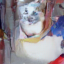

In [16]:
inference_timesteps = 64
# torch.random.manual_seed(1)
pred = sample(
    diff,
    (1,in_channels,64,64),
    128,
    inference_timesteps,
    normalize_pred=False,
    regenerate_noise=False,
    rescale_generated_noise=False
).cpu()#.sigmoid()
print(pred.mean(),pred.std())
pred-=pred.min()
pred/=pred.max()
T.ToPILImage()(pred[0])